**We did some analyses before narrowing down to a solid research question and wanted to include them even though they are not related to our topic.**

In [1]:
#imports
import pandas as pd
import numpy as np
from collections import Counter

**This is a K-Nearest Neighbors Classifier model to predict which type of article (section name) each article is given its headline, lead paragraph, and other variables.**

In [2]:
archive = pd.read_csv("archive.csv")

In [3]:
archive_df = archive[["byline.original", "document_type", "headline.main", "lead_paragraph", "pub_date_str",
                     "word_count", "section_name"]].dropna()

archive_df = archive_df[0:1000]

words = (
    archive_df["lead_paragraph"].
    str.lower().
    str.replace("<br />", " ").
    str.replace("[^\w\s]", "").
    str.split()
).dropna()

bag_of_words = words.apply(Counter)

tf = pd.DataFrame(list(bag_of_words))
tf.fillna(0, inplace = True)

total = pd.DataFrame()
for i in range(len(archive_df)-1):
    a = tf[tf.index == i].sum(axis=0).sort_values(ascending=False)[:50] #only takes 50 most common words from each article
    total = total.append(a, ignore_index = True)

In [4]:
total = total.fillna(0)
print(len(total))
total.head()

999


,1,1970s,and,combinations,extra,extraordinarily,factor,fell,fellow,female,...,16,attacks,botox,headaches,per,placebos,resulted,benefits,substitutes,sugar
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
total.columns[total.isna().any()].tolist()
#no values are NA here

[]

In [6]:
df = (total.iloc[:, :-1] >= 1).sum(axis=0)
idf = np.log(len(total.iloc[:, :-1]) / df)
tf_idf = total.iloc[:, :-1] * idf 
tf_idf["section_name"] = archive_df["section_name"]
tf_idf.head()

,1,1970s,and,combinations,extra,extraordinarily,factor,fell,fellow,female,...,16,attacks,botox,headaches,per,placebos,resulted,benefits,substitutes,section_name
0,4.50886,5.297317,0.762569,6.213608,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Obituaries
1,0.00000,0.000000,0.762569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,World
2,0.00000,0.000000,1.525138,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U.S.
3,0.00000,0.000000,0.762569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [7]:
bad_cols = tf_idf.columns[tf_idf.isna().any()].tolist()
bad_cols.remove("section_name")
#these somehow made it through without having any values, we'll drop them

In [8]:
bad_cols

[]

In [9]:
#drops the columns that are all 0s
tf_idf = tf_idf.drop(bad_cols, axis = 1)
#only rows that have no section name remain as NA
tf_idf.columns[tf_idf.isna().any()].tolist()

['section_name']

In [10]:
# I am going to save the data frame at this point for later 
# when we'll use the rows with NA section names for our test data later
tf_idf_to_model = tf_idf

In [11]:
#I'll drop the rows with NA section names here
tf_idf = tf_idf.dropna()
len(tf_idf)

859

In [12]:
#Lets add word count to our model

tf_idf["word_count"] = archive_df["word_count"]
tf_idf.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,1,1970s,and,combinations,extra,extraordinarily,factor,fell,fellow,female,...,attacks,botox,headaches,per,placebos,resulted,benefits,substitutes,section_name,word_count
0,4.50886,5.297317,0.762569,6.213608,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Obituaries,660
1,0.00000,0.000000,0.762569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,World,1326
2,0.00000,0.000000,1.525138,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U.S.,1779
5,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Arts,469
6,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,World,778


In [13]:
tf_idf.columns[tf_idf.isna().any()].tolist()
#Nothing is missing!

[]

In [14]:
tf_idf["section_name"].value_counts().head()

U.S.       135
World      105
Arts        68
Opinion     67
Sports      54
Name: section_name, dtype: int64

In [15]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

vec = DictVectorizer(sparse = False)
scaler = QuantileTransformer()

X_train = tf_idf.drop("section_name", axis=1)
y_train = tf_idf["section_name"]
X_train_dict = X_train.to_dict(orient="records")
model = KNeighborsClassifier(n_neighbors=10)

pipeline = Pipeline([('vectorizer', vec), ('scaler', scaler), ('fit', model)])
np.mean(cross_val_score(pipeline, X_train_dict, y_train == "U.S.", cv=5, scoring="recall"))

0.02222222222222222

This is a pretty bad model but that goes to show that predicting the section name of an article just based on the first paragraph is a tough thing for this kind of model to do.

Let's use it to predict those articles from earlier that had NA for their section names!

In [16]:
unknown_test_idf = tf_idf_to_model[tf_idf_to_model["section_name"].isnull()]
known_train_idf = tf_idf_to_model[tf_idf_to_model["section_name"].notnull()]
print(len(unknown_test_idf), len(known_train_idf))

140 859


In [17]:
vec = DictVectorizer(sparse=False)
scaler = QuantileTransformer()
X_dict_idf = known_train_idf.drop("section_name", axis = 1).to_dict(orient = "records")
y_idf = known_train_idf["section_name"]

# calculates estimate of test error based on 5-fold cross validation
def get_cv_error(k):
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    f1 = np.mean(-cross_val_score(
        pipeline, X_dict_idf, y_idf == "U.S.", 
        cv=2, scoring="precision"
    ))
    return f1
    
ks = pd.Series(range(1, 11))
ks.index = range(1, 11)
test_errs = ks.apply(get_cv_error)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
test_errs.plot.line()
best_k = test_errs.sort_values(ascending=False).idxmax()
print("Optimal K: ", best_k)

Optimal K:  7


In [19]:
from sklearn.metrics import confusion_matrix

X_train_idf = known_train_idf.drop("section_name", axis = 1)
y_train_idf = known_train_idf["section_name"]

scaler = QuantileTransformer()
scaler.fit(X_train_idf)
X_train_sc_idf = scaler.transform(X_train_idf)

model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train_sc_idf, y_train_idf)

predictions3 = model.predict(X_train_idf)

Let's test what the confusion matrix looks like!

In [20]:
known_train_idf["section_name"].value_counts().head()

U.S.       135
World      105
Arts        68
Opinion     67
Sports      54
Name: section_name, dtype: int64

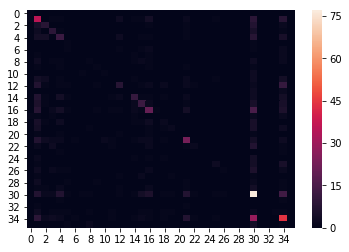

In [21]:
conf_matrix = pd.DataFrame(confusion_matrix(known_train_idf["section_name"], predictions3))
conf_matrix

import seaborn
seaborn.heatmap(conf_matrix)

Now I will predict the section names of the 140 articles in our dataset that didn't have section names:

In [22]:

X_train_idf = known_train_idf.drop("section_name", axis = 1)
y_train_idf = known_train_idf["section_name"]


scaler = QuantileTransformer()
scaler.fit(X_train_idf)
X_train_sc_idf = scaler.transform(X_train_idf)


model = KNeighborsClassifier(n_neighbors= best_k)
model.fit(X_train_sc_idf, y_train_idf)


x_new_idf = unknown_test_idf.drop("section_name", axis = 1)
x_new_sc_idf = scaler.transform(x_new_idf)


predictions4 = model.predict(x_new_sc_idf)
predictions4

array(['U.S.', 'U.S.', 'U.S.', 'U.S.', 'Opinion', 'World', 'U.S.', 'U.S.',
       'Opinion', 'U.S.', 'World', 'U.S.', 'U.S.', 'Opinion', 'Opinion',
       'U.S.', 'U.S.', 'Opinion', 'U.S.', 'Obituaries', 'Technology',
       'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'U.S.', 'Opinion', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'U.S.', 'U.S.', 'Opinion', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'World', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'The Learning Network', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'The Learning Network', 'U.S.', 'U.S.', 'Opinion', 'U.S.', 'U.S.',
       'Opinion', 'U.S.', 'U.S.', 'U.S.', 'Opinion', 'U.S.', 'U.S.',
       'U.S.', 'U.S.', 'U.S.', 'Opinion', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
       'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.', 'U.S.',
      

U.S. was the most common section name so it's not surprising that it was the most commonly predicted section name, though it may have been a bit disproportionate here.

**We also did a K-Nearest Neighbors model on the NYT hardcover fiction bestseller list to predict where on the list a book would be based on its description**

In [6]:
#Books cleaning

date_list = ["2018-05-01", "2018-06-01", "2018-07-01", "2018-08-01","2018-09-01", "2018-10-01",
             "2018-11-01", "2018-12-01", "2019-01-01", "2019-02-01"] 
#first day of the last 10 months to avoid much overlap of books on multiple lists

json_list = []
for date in date_list:
    link = "https://api.nytimes.com/svc/books/v3/lists/%s/hardcover-fiction.json?api-key=%s" %(date, apikey)
    resp = requests.get(link)
    json_list.append(pd.DataFrame(json_normalize(resp.json()['results']['books'])))
    time.sleep(0.5)

df = pd.concat(json_list, ignore_index = True)

In [7]:
books_df_dups = df[["title", "weeks_on_list", "author", "description", "publisher", "rank"]]
books_df = books_df_dups.drop_duplicates("title", keep = "last") #getting rid of books that appear more than once, keeping most recent row only
books_df.head()

,title,weeks_on_list,author,description,publisher,rank
1,AFTER ANNA,2,Lisa Scottoline,A woman marries a widower and reunites with he...,St. Martin's,2
2,NOIR,1,Christopher Moore,"In the summer of 1947, a woman and an Air Forc...",Morrow,3
3,I'VE GOT MY EYES ON YOU,3,Mary Higgins Clark,A high school guidance counselor tries to unco...,Simon & Schuster,4
4,THE FEMALE PERSUASION,3,Meg Wolitzer,The relationship between a college freshman an...,Riverhead,5
10,SHOOT FIRST,2,Stuart Woods,Stone Barrington searches for the person who p...,Putnam,11


In [8]:
books_df = books_df.reset_index()
books_df.to_csv("books_df.csv")

In [ ]:
co_df = pd.DataFrame()
import time
for i in range(1,11):
    resp = requests.get('https://api.nytimes.com/svc/search/v2/articlesearch.json?fq=headline:("Colorado")&page=%d&api-key=%s' % (i, apikey))
    co_headlines = 

In [25]:
books_df = pd.read_csv("books_df.csv")

In [26]:
from collections import Counter

words = (
    books_df["description"].
    str.lower().
    str.replace("<br />", " ").
    str.replace("[^\w\s]", "").
    str.split()
).dropna()

bag_of_words = words.apply(Counter)

tf = pd.DataFrame(list(bag_of_words))
tf.fillna(0, inplace = True);

In [27]:
total = pd.DataFrame()
for i in range(len(books_df.title)-1):
    a = tf[tf.index == i].sum(axis=0).sort_values(ascending=False)[:50] #top 50 words of the description, but they are usually less than 50 words long
    total = total.append(a, ignore_index = True)

total.fillna(0, inplace=True)
total.head()

,a,after,and,daughter,fbi,federal,feelings,felony,feminism,feminist,...,killer,leaves,letters,pendergast,removes,track,born,england,explores,reacher
0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
import numpy as np

df = (total.iloc[:, :-1] > 0).sum(axis=0)
idf = np.log(len(total.iloc[:, :-1]) / df)
tf_idf = total.iloc[:, :-1] * idf 
tf_idf["rank_"] = books_df["rank"]
tf_idf["author_"] = books_df["author"] #adding 3 more variables to the model
tf_idf["publisher_"] = books_df["publisher"]
tf_idf["weeks_on_list"] = books_df["weeks_on_list"]

In [29]:
tf_idf.columns[tf_idf.isna().any()].tolist()

['zeus']

In [30]:
tf_idf = tf_idf.drop("zeus", axis=1)

In [31]:
tf_idf.columns[tf_idf.isna().any()].tolist() #nothing is missing, so lets model!

[]

In [32]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

vec = DictVectorizer(sparse = False)
scaler = QuantileTransformer()

X_train = tf_idf.drop("rank_", axis=1)
y_train = tf_idf["rank_"]
X_train_dict = X_train.to_dict(orient="records")
model = KNeighborsRegressor(n_neighbors=10)

pipeline = Pipeline([('vectorizer', vec), ('scaler', scaler), ('fit', model)])
np.sqrt(np.mean(-cross_val_score(pipeline, X_train_dict, y_train, cv=5, scoring="neg_mean_squared_error")))

4.3974101894488999

This is okay considering the range here is between 1 and 15

**This is the first looks at the API we did**

In [2]:
#imports
import pandas as pd
import requests
from pandas.io.json import json_normalize
import time

apikey = 'OOFXXAG7cuVc2q9C0EekCNqWm4lzERfm'

In [3]:
archive = pd.read_csv("archive.csv")

In [3]:
archive.document_type.value_counts()

article       6531
multimedia     378
audio           68
Name: document_type, dtype: int64

In [4]:
archive["pub_date_str"].value_counts().sort_values().plot.bar()

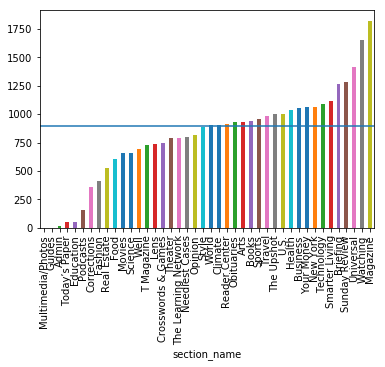

In [5]:
archive.groupby('section_name')['word_count'].mean().sort_values(
).plot.bar().axhline(y=archive['word_count'].mean()) #make this bigger

In [6]:
#check out the "most popular" endpoint of the API

resp = requests.get('https://api.nytimes.com/svc/mostpopular/v2/viewed/7.json?api-key=%s' %apikey)
nyt_json = resp.json()
nyt = json_normalize(nyt_json['results'])
nyt.head()

,abstract,adx_keywords,asset_id,byline,column,des_facet,geo_facet,id,media,org_facet,per_facet,published_date,section,source,title,type,uri,url,views
0,A sprawling federal investigation accuses 50 p...,College Admissions Scandal (2019);Colleges and...,100000006406075,"By JENNIFER MEDINA, KATIE BENNER and KATE TAYLOR",None,"[COLLEGES AND UNIVERSITIES, ADMISSIONS STANDAR...",,100000006406075,"[{'type': 'image', 'subtype': 'photo', 'captio...","[COLLEGE ADMISSIONS SCANDAL (2019), BRIBERY AN...","[SINGER, WILLIAM RICK, HUFFMAN, FELICITY, LOUG...",2019-03-12,U.S.,The New York Times,"Actresses, Business Leaders and Other Wealthy ...",Article,nyt://article/bac76e87-b5fc-54fa-8c0f-46a0688e...,https://www.nytimes.com/2019/03/12/us/college-...,1
1,The actresses Felicity Huffman and Lori Loughl...,College Admissions Scandal (2019);Admissions S...,100000006406229,By REBECCA HALLECK,None,"[ADMISSIONS STANDARDS, COLLEGES AND UNIVERSITI...",,100000006406229,"[{'type': 'image', 'subtype': 'photo', 'captio...","[COLLEGE ADMISSIONS SCANDAL (2019), CHEATING]","[HUFFMAN, FELICITY, LOUGHLIN, LORI, GIANNULLI,...",2019-03-12,U.S.,The New York Times,Who’s Been Charged in the College Admissions C...,Article,nyt://article/50b479fd-7f67-54d5-91ec-b60178e8...,https://www.nytimes.com/2019/03/12/us/felicity...,2
2,"“Break break, request back to home,” the capta...",Boeing 737 Max Groundings and Safety Concerns ...,100000006410242,By SELAM GEBREKIDAN and JAMES GLANZ,None,[BOEING 737 MAX GROUNDINGS AND SAFETY CONCERNS...,,100000006410242,"[{'type': 'image', 'subtype': 'photo', 'captio...","[BOEING COMPANY, FEDERAL AVIATION ADMINISTRATI...","[GETACHEW, YARED]",2019-03-14,World,The New York Times,"Boeing 737 Max Hit Trouble Right Away, Pilot’s...",Article,nyt://article/63411a1f-beed-55ff-99b5-7c382acf...,https://www.nytimes.com/2019/03/14/world/boein...,3
3,"The attack on two mosques, which appeared to h...","Murders, Attempted Murders and Homicides;Chris...",100000006412038,By THE NEW YORK TIMES,None,"[MURDERS, ATTEMPTED MURDERS AND HOMICIDES, CHR...","[NEW ZEALAND, CHRISTCHURCH (NEW ZEALAND)]",100000006412038,"[{'type': 'image', 'subtype': 'photo', 'captio...","[TERRORISM, MUSLIMS AND ISLAM, SOCIAL MEDIA]",,2019-03-15,World,The New York Times,Jacinda Ardern Consoles Families After New Zea...,Article,nyt://article/54ac784c-9e89-5526-8fa3-4e7734eb...,https://www.nytimes.com/2019/03/15/world/asia/...,4
4,China was the first major country to ground th...,Airlines and Airplanes;Boeing Company;Aviation...,100000006404643,"By DENISE LU, ALLISON McCANN, JIN WU and K.K. ...",,"[AIRLINES AND AIRPLANES, AVIATION ACCIDENTS, S...",[ADDIS ABABA (ETHIOPIA)],100000006404643,"[{'type': 'image', 'subtype': 'photo', 'captio...","[BOEING COMPANY, LION AIR, ETHIOPIAN AIRLINES,...",,2019-03-11,World,The New York Times,"From 8,600 Flights to Zero: Grounding the Boei...",Interactive,nyt://interactive/7fcc105c-d025-5f27-841e-e002...,https://www.nytimes.com/interactive/2019/03/11...,5


In [8]:
#Headlines

In [4]:
archive_df_og = archive

In [11]:
lyrics = archive_df_og["headline.main"]

In [12]:
def train_markov_chain(lyrics):
    """
    Args:
      - lyrics: a list of strings, where each string represents
                the lyrics of one song by an artist.
    
    Returns:
      A dict that maps a tuple of 2 words ("bigram") to a list of
      words that follow that bigram, representing the Markov
      chain trained on the lyrics.
    """
    chain = {(None, "<START>"): []}
    for lyric in lyrics:
        lyric = "<START> " + lyric + " <END>"
        
#         print("Song: ", lyric)
#         break
        words = str(lyric).split(" ")
        #for word in range(len(words)):
        i=0
        while words[i] != "<END>":
            #print("word:", words[i], " number ", i, " out of ", len(words))
            if words[i] == "<START>":
                chain[(None, words[i])].append(words[i+1])
            chain.setdefault((words[i], words[i+1]), [])
            if words[i+1] != "<END>":
                chain[(words[i], words[i + 1])].append(words[i+2])
            if words[i+1] == "<END>":
                chain[(words[i], words[i + 1])].append("<END>")
            i += 1
        if words[-1] == "<END>":
            chain[(words[-2], words[-1])].append(None)
            
        
    return chain

In [13]:
import pickle
pickle.dump(lyrics, open("lyrics.pkl", "wb"))

import pickle
lyrics = pickle.load(open("lyrics.pkl", "rb"))

chain = train_markov_chain(lyrics)

In [14]:
import random

def generate_new_lyrics(chain):
    """
    Args:
      - chain: a dict representing the Markov chain,
               such as one generated by generate_new_lyrics()
    
    Returns:
      A string representing the randomly generated song.
    """
    wordlist = []
    wordlist.append(random.choice(chain[(None, "<START>")]))
    wordlist.append(random.choice(chain[("<START>", wordlist[-1])]))
    for x in range(len(chain)):
        #print("(wordlist[-2], wordlist[-1])= ", (wordlist[-2], wordlist[-1]))
        wordlist.append(random.choice(chain[(wordlist[-2], wordlist[-1])]))
        if wordlist[-1] == "<END>":
            break

    lyrics = " ".join(wordlist[:-1])
    return "\n".join(lyrics.split("<N>"))

In [15]:
print(generate_new_lyrics(chain))

Charles J. Hynes, Brooklyn D.A. in a Warplane


In [16]:
headline_list = []
for i in range(10):
    headline_list.append(generate_new_lyrics(chain))
    
headline_list #these are just actual headlines, we need unigram

['Harold Bradley, a Nashville Studio Master, Is Dead at 95; Groundbreaking African-American Bishop',
 '‘Miss Bala’ Review: Gina Rodriguez Finds the Wrong Place at the Border Wall Donations After Fund-Raiser Falls Short',
 'Britney Spears Announces ‘Indefinite Work Hiatus,’ Cancels Las Vegas Massacre: Sell the Gunman’s Weapons, or Destroy Them',
 'I’m Prepared to Talk About the Trafficker Who Incriminated a Mexican President Peña Nieto Took $100 Million Bribe, Witness at El Chapo Trial: Kingpin Used Spyware to Obsessively Monitor His Wife and Mistress',
 '‘Broad City’ Is Ending. Here’s What We Saw at London Fashion Week Men’s',
 'Las principales noticias del jueves',
 'The Marvelous Ms. Elaine May',
 'What Students Are Saying About: How to Get Preschoolers to Share',
 'What Advocates of Legalizing Pot Don’t Want You to Know ',
 'T.S.A. Agents Refuse to Work Day Is Every Day for This Collector']

In [17]:
#Unigram

In [18]:
lyrics = archive_df_og["headline.main"]

In [19]:
lyrics[0]

'Daryl Dragon, of the Captain and Tennille Pop Duo, Dies at 76'

In [20]:
num_list = []
for lyric in lyrics:
    words = str(lyric).split(" ")
    num_list.append(len(words))
    
pd.DataFrame(num_list).mean() #average headline is between 9 and 10 words long

0    9.134728
dtype: float64

In [21]:
def train_markov_chain(lyrics):
    """
    Args:
      - lyrics: a list of strings, where each string represents
                the lyrics of one song by an artist.
    
    Returns:
      A dict that maps a single word ("unigram") to a list of
      words that follow that word, representing the Markov
      chain trained on the lyrics.
    """
    chain = {"<START>": []}
    for lyric in lyrics:
        lyric = "<START> " + lyric + " <END>"
        #print("Song: ", lyric)
        words = str(lyric).split(" ")
        for word in range(len(words)):
            #print("word: ", word)
            chain.setdefault(words[word], [])
            if words[word] != "<END>":
                #print("words[word]: ", words[word])
                if words[word+1] != "<END>":
                    chain[words[word]].append(words[word+1])
                    #print("first")
                if words[word] == "<START>":
                    #print("second")
                    if words[word + 1] == "<NA>":
                        #print("third")
                        chain[words[word]].append(words[word+2])
            if words[word] == "<END>":
                #print("words[word]: ", words[word])
                #print("fourth")
                chain[words[word-1]].append("<END>")
                #print(words[word-1])
        
    return chain

In [22]:
import pickle
lyrics = pickle.load(open("lyrics.pkl", "rb"))

chain = train_markov_chain(lyrics)

In [23]:
import random

def generate_new_lyrics(chain):
    """
    Args:
      - chain: a dict representing the Markov chain,
               such as one generated by generate_new_lyrics()
    
    Returns:
      A string representing the randomly generated song.
    """
    
    
    words = []
    words.append(random.choice(chain["<START>"]))
    for x in range(len(chain)):
        #print(words)
        rand = random.choice(chain[words[-1]])
        if rand == "<END>":
            break
        words.append(rand)
        if x > 10: #limit to 10 words per headline, about average
            break

    lyrics = " ".join(words[:-1])
    return "\n".join(lyrics.split("<N>"))

In [24]:
headline_list = []
for i in range(10):
    headline_list.append(generate_new_lyrics(chain))
    
headline_list 

['At El Chapo’s',
 'Indian Family Is There Is Legalizing Pot Don’t Kiss Your Wednesday Evening',
 'Hundreds Still Topic A Breakup Leaves His Juliet. Their',
 'What Happened in Radiant',
 'The Games Animals Play Harvey Weinstein-Like Character ... Stony Brook, N.Y. Fires',
 'Haley Joel Osment Plays Roger Stone’s Statement Responding to Sell Everything. New',
 'Hands-On',
 'Trump Administration Freezes Raises for a Gay Brazilian Lawmaker Floats Bill James',
 'What’s',
 '11 Indicted in a Nurse. The Fleecing of Sexual Assault on Our']

In [25]:
#Florida Man 

In [29]:
offset_list = [0,20,40,60,80,100,120,140,160] #,180] #limited to 10 calls at once
article_list = []
for i in offset_list:
    resp = requests.get("https://api.nytimes.com/svc/search/v2/articlesearch.json?fq=headline:('florida')&offset=%d&api-key=%s"% (i, apikey))
    fla = resp.json()
    article_list.append(json_normalize(fla["response"]["docs"]))
    time.sleep(0.5)

#attempt to get more than 10 api calls
# time.sleep(5)
# offset_list2 = [200,220,240,260,280,300,320,340,360,380]
# for j in offset_list2:
#     resp = requests.get("https://api.nytimes.com/svc/search/v2/articlesearch.json?fq=headline:('florida')&offset=%d&api-key=%s"% (i, apikey))
#     fla = resp.json()
#     article_list.append(json_normalize(fla["response"]["docs"]))
#     time.sleep(0.5)
    
florida_articles = pd.concat(article_list, ignore_index=True)

In [31]:
len(florida_articles)

90

In [32]:
lyrics = florida_articles["headline.main"]

In [33]:
def train_markov_chain(lyrics):
    """
    Args:
      - lyrics: a list of strings, where each string represents
                the lyrics of one song by an artist.
    
    Returns:
      A dict that maps a tuple of 2 words ("bigram") to a list of
      words that follow that bigram, representing the Markov
      chain trained on the lyrics.
    """
    chain = {(None, "<START>"): []}
    for lyric in lyrics:
        lyric = "<START> " + lyric + " <END>"
        
#         print("Song: ", lyric)
#         break
        words = str(lyric).split(" ")
        #for word in range(len(words)):
        i=0
        while words[i] != "<END>":
            #print("word:", words[i], " number ", i, " out of ", len(words))
            if words[i] == "<START>":
                chain[(None, words[i])].append(words[i+1])
            chain.setdefault((words[i], words[i+1]), [])
            if words[i+1] != "<END>":
                chain[(words[i], words[i + 1])].append(words[i+2])
            if words[i+1] == "<END>":
                chain[(words[i], words[i + 1])].append("<END>")
            i += 1
        if words[-1] == "<END>":
            chain[(words[-2], words[-1])].append(None)
            
        
    return chain

In [34]:
import pickle
pickle.dump(lyrics, open("lyrics.pkl", "wb"))

import pickle
lyrics = pickle.load(open("lyrics.pkl", "rb"))

chain = train_markov_chain(lyrics)

In [35]:
import random

def generate_new_lyrics(chain):
    """
    Args:
      - chain: a dict representing the Markov chain,
               such as one generated by generate_new_lyrics()
    
    Returns:
      A string representing the randomly generated song.
    """
    wordlist = []
    wordlist.append(random.choice(chain[(None, "<START>")]))
    wordlist.append(random.choice(chain[("<START>", wordlist[-1])]))
    for x in range(len(chain)):
        #print("(wordlist[-2], wordlist[-1])= ", (wordlist[-2], wordlist[-1]))
        wordlist.append(random.choice(chain[(wordlist[-2], wordlist[-1])]))
        if wordlist[-1] == "<END>":
            break

    lyrics = " ".join(wordlist[:-1])
    return "\n".join(lyrics.split("<N>"))

In [36]:
#print(chain[("Florida", "man")]) #no Florida man headlines :/

In [37]:
headline_list = []
for i in range(10):
    headline_list.append(generate_new_lyrics(chain))
    
headline_list 

['FLORIDA PARKS; Recreation Sites Abound In the Sunshine State Best Season By Shape and Color Reappearing River Crowded in Summer',
 'Vigil Begun as Florida Coed Is Punished for Posing Nude',
 'Chilly Wind, Warm Words Welcome Mets in Florida; 27 METS ARRIVE AT FLORIDA CAMP',
 "Housewife Learning to Call 'Em Out at Home; Mrs. Gera Studies Umpire's Art at Florida School",
 'Florida and Georgia Golfers Advance in Senior Tourney',
 'Florida and Georgia Golfers Advance in Senior Tourney',
 'Two Musicians Are Killed In Florida Highway Crash',
 'Florida and Georgia Golfers Advance in Senior Tourney',
 'Vigil Begun as Florida Coed Is Punished for Posing Nude',
 'Chilly Wind, Warm Words Welcome Mets in Florida; 27 METS ARRIVE AT FLORIDA CAMP']

In [38]:
#unigram

In [39]:
def train_markov_chain(lyrics):
    """
    Args:
      - lyrics: a list of strings, where each string represents
                the lyrics of one song by an artist.
    
    Returns:
      A dict that maps a single word ("unigram") to a list of
      words that follow that word, representing the Markov
      chain trained on the lyrics.
    """
    chain = {"<START>": []}
    for lyric in lyrics:
        lyric = "<START> " + lyric + " <END>"
        #print("Song: ", lyric)
        words = str(lyric).split(" ")
        for word in range(len(words)):
            #print("word: ", word)
            chain.setdefault(words[word], [])
            if words[word] != "<END>":
                #print("words[word]: ", words[word])
                if words[word+1] != "<END>":
                    chain[words[word]].append(words[word+1])
                    #print("first")
                if words[word] == "<START>":
                    #print("second")
                    if words[word + 1] == "<NA>":
                        #print("third")
                        chain[words[word]].append(words[word+2])
            if words[word] == "<END>":
                #print("words[word]: ", words[word])
                #print("fourth")
                chain[words[word-1]].append("<END>")
                #print(words[word-1])
        
    return chain

In [40]:
import pickle
lyrics = pickle.load(open("lyrics.pkl", "rb"))

chain = train_markov_chain(lyrics)

In [41]:
import random

def generate_new_lyrics(chain):
    """
    Args:
      - chain: a dict representing the Markov chain,
               such as one generated by generate_new_lyrics()
    
    Returns:
      A string representing the randomly generated song.
    """
    
    
    words = []
    words.append(random.choice(chain["<START>"]))
    for x in range(len(chain)):
        #print(words)
        rand = random.choice(chain[words[-1]])
        if rand == "<END>":
            break
        words.append(rand)
        if x > 10: #limit to 10 words per headline, about average
            break

    lyrics = " ".join(words[:-1])
    return "\n".join(lyrics.split("<N>"))

In [42]:
print(chain[("Florida")]) #no Florida man headlines :/

['Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and', 'Coed', 'Murder', 'Area', '<END>', '<END>', 'School', 'Highway', 'and']


In [43]:
headline_list = []
for i in range(10):
    headline_list.append(generate_new_lyrics(chain))
    
headline_list 

['Jury Deadlock in',
 'Schad Triumphs in',
 'Two Musicians Are Killed In the Sunshine State Best Season By Shape',
 'Jury Deadlock in Florida; 27 METS ARRIVE AT FLORIDA',
 'Vigil Begun as Florida Highway',
 'Vigil Begun as Florida Murder',
 "Housewife Learning to Call 'Em Out at Home; Mrs. Gera Studies Umpire's",
 'Two Musicians Are Killed In the Sunshine State Best Season By Shape',
 'Housewife Learning to Most of Florida Highway',
 'Two Musicians Are Killed In Florida Coed Is Punished for Posing']